# Initializing things

In [1]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle

In [3]:
# Get all the files after sept
# Probably horrible implementation but I just want something that works right now

aug = glob.glob(os.path.join('D:', 'SafeGraph_Data', '2020', '08', '**', '*.gz'))
sept = glob.glob(os.path.join('D:', 'SafeGraph_Data', '2020', '09', '**', '*.gz'))
oct = sept_files = glob.glob(os.path.join('D:', 'SafeGraph_Data', '2020', '10', '**', '*.gz'))
nov = sept_files = glob.glob(os.path.join('D:', 'SafeGraph_Data', '2020', '11', '**', '*.gz'))
dec = sept_files = glob.glob(os.path.join('D:', 'SafeGraph_Data', '2020', '12', '**', '*.gz'))

files = aug + sept + oct + nov + dec

files

['D:SafeGraph_Data\\2020\\08\\01\\2020-08-01-social-distancing.csv.gz',
 'D:SafeGraph_Data\\2020\\08\\02\\2020-08-02-social-distancing.csv.gz',
 'D:SafeGraph_Data\\2020\\08\\03\\2020-08-03-social-distancing.csv.gz',
 'D:SafeGraph_Data\\2020\\08\\04\\2020-08-04-social-distancing.csv.gz',
 'D:SafeGraph_Data\\2020\\08\\05\\2020-08-05-social-distancing.csv.gz',
 'D:SafeGraph_Data\\2020\\08\\06\\2020-08-06-social-distancing.csv.gz',
 'D:SafeGraph_Data\\2020\\08\\07\\2020-08-07-social-distancing.csv.gz',
 'D:SafeGraph_Data\\2020\\08\\08\\2020-08-08-social-distancing.csv.gz',
 'D:SafeGraph_Data\\2020\\08\\09\\2020-08-09-social-distancing.csv.gz',
 'D:SafeGraph_Data\\2020\\08\\10\\2020-08-10-social-distancing.csv.gz',
 'D:SafeGraph_Data\\2020\\08\\11\\2020-08-11-social-distancing.csv.gz',
 'D:SafeGraph_Data\\2020\\08\\12\\2020-08-12-social-distancing.csv.gz',
 'D:SafeGraph_Data\\2020\\08\\13\\2020-08-13-social-distancing.csv.gz',
 'D:SafeGraph_Data\\2020\\08\\14\\2020-08-14-social-distancing.c

In [4]:
df_original = []
# Adds every csv.gz file as a panda dataframe to list df_original
for file in files:
    df = pd.read_csv(file, compression='gzip', usecols=['origin_census_block_group', 
                                                         'device_count', 'completely_home_device_count',
                                                        'destination_cbgs'])
    df['origin_census_block_group'] = df['origin_census_block_group'].astype(str)
    # Filters for Honolulu county
    temp = df['origin_census_block_group'].str.contains('^15003')
    df_original.append(df[temp])


# Miscellaneous functions/variables

In [5]:
# Save the extracted csvs as a pickle
pickle_out = open("uh.pickle", "wb")
pickle.dump(df_original, pickle_out)
pickle_out.close()

In [6]:
# Load the pickle with the extracted csvs
pickle_in = open("uh.pickle", "rb")
df_original = pickle.load(pickle_in)
print(df_original[0].head())
print(len(df_original))

     origin_census_block_group  device_count  completely_home_device_count  \
327               150030078092            93                            21   
791               150030077022           131                            37   
1048              150030075061            31                             7   
1801              150030099044            55                            18   
2483              150030095021            80                            22   

                                       destination_cbgs  
327   {"150030086121":1,"150030084061":1,"1500300800...  
791   {"150030077022":105,"150030075021":1,"15003008...  
1048  {"150030075041":1,"150010215092":1,"1307303050...  
1801  {"150030086121":3,"150030087022":4,"1500300800...  
2483  {"150030036012":2,"150039806001":1,"2909501850...  
120


In [7]:
print(df_original[0].head())
print(len(df_original))

     origin_census_block_group  device_count  completely_home_device_count  \
327               150030078092            93                            21   
791               150030077022           131                            37   
1048              150030075061            31                             7   
1801              150030099044            55                            18   
2483              150030095021            80                            22   

                                       destination_cbgs  
327   {"150030086121":1,"150030084061":1,"1500300800...  
791   {"150030077022":105,"150030075021":1,"15003008...  
1048  {"150030075041":1,"150010215092":1,"1307303050...  
1801  {"150030086121":3,"150030087022":4,"1500300800...  
2483  {"150030036012":2,"150039806001":1,"2909501850...  
120


In [8]:
# It's weird to import funcs from other notebooks so I just copy pasted some code
# I should switch to another IDE

# Get file with all the info on zips and CBGs
df_zip = pd.read_excel(r'C:\Users\Victor\Documents\covid research stuff\ZIP_TRACT_092020.xlsx')

# Make dictionary out of the values
zips = dict(zip(df_zip.TRACT.astype('str'), df_zip.ZIP))

hawaii_zips = {k:v for k,v in zips.items() if (v > 96700 and v < 96899)}

hawaii_zips['15003009801']

96792

In [9]:
# Returns the zip given the cbg in hawaii
def converter(cbg):
    zipCBG = None
    # Checks each cbg if it's a given Hawaiian zipcode
    for key in hawaii_zips:
        if key in cbg:
            zipCBG = key
    # cbg in Hawaii, but not in list so cbg is returned
    if zipCBG == None:
        return cbg
    return hawaii_zips[zipCBG]

# Working with the data

In [10]:
visits = []
visits_zips = []

# I'm pretty sure this is horribly inefficient (it iterates over every spreadsheet)
# But it works, so improve it later
# For every dataframe, iterate over destination_cbgs for all tracts, and sum the visits to waianae's tracts
for df in df_original:
    zip_dic = {}
    day_visits = 0
    # Checks every row, column in dataframe
    for index, row in df.iterrows():
        origin_cbg = row['origin_census_block_group']
        raw = row['destination_cbgs']
        dic = json.loads(raw)
        # Checks every key in destination_cbg dict for uh manoa
        for key in dic:
            if converter(key) == 96822:
                day_visits += dic[key]
                cbg_zip = converter(origin_cbg)
                if cbg_zip in zip_dic:
                    zip_dic[cbg_zip] += dic[key]
                else:
                    zip_dic[cbg_zip] = dic[key]
    visits.append(day_visits)
    visits_zips.append(zip_dic)

In [11]:
# Double checking if everything is correct

test = 0
dicta = visits_zips[0]

for key in dicta:
    test += dicta[key]
    
print(visits_zips[0])
print(test)
print(visits[0])

{96701: 40, 96818: 95, 96791: 3, 96786: 9, 96816: 68, 96822: 2120, 96797: 81, 96707: 38, 96848: 5, 96819: 77, 96744: 55, 96824: 5, 96731: 3, 96817: 125, 96825: 37, 96815: 40, 96857: 3, 96814: 52, 96792: 24, 96826: 76, 96821: 23, 96706: 49, 96828: 17, 96734: 23, 96789: 41, 96859: 6, 96762: 1, 96836: 5, 96709: 9, 96813: 36, 96837: 1, 96782: 33, 96830: 5, 96823: 13, 96795: 6, 96730: 1, 96861: 1, '150039900010': 2, 96850: 4, 96898: 3, 96839: 5, 96858: 2}
3242
3242


# Graphing

In [12]:
# Making list of dates for plotting
import datetime

dates = pd.date_range(start=datetime.datetime(2020, 8, 1), end=datetime.datetime(2020, 11, 28), freq = 'D')

dates

DatetimeIndex(['2020-08-01', '2020-08-02', '2020-08-03', '2020-08-04',
               '2020-08-05', '2020-08-06', '2020-08-07', '2020-08-08',
               '2020-08-09', '2020-08-10',
               ...
               '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
               '2020-11-27', '2020-11-28'],
              dtype='datetime64[ns]', length=120, freq='D')

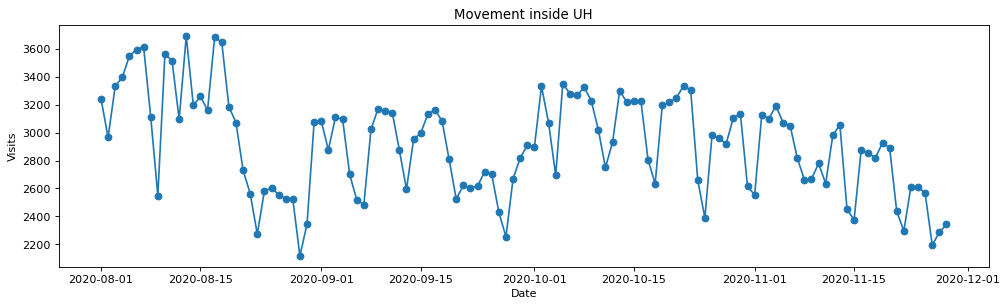

In [14]:
# Total amount of movement in UH

plt.figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')

plt.title('Movement inside UH')
plt.xlabel('Date')
plt.ylabel('Visits')
plt.plot(dates, visits, '-o')
plt.show()

In [15]:
dfW = pd.Series(visits).to_frame()

pd.DataFrame(dfW).to_excel('uh.xlsx', engine='xlsxwriter')